## SKLearn Linear Regression vs. Gradient Descent

Predicting house prices.

Compare output of sklearn LinearRegression with manual computation of **Gradient Descent**.

Including:
* Train Test Split
* Scaling
* Feature Generation
* Mean Squared Error
* Mean Absolute Error
* Prediction

No hyperparameters

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split, KFold

# Data Setup

**Load and condition data**

In [3]:
df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00477/Real%20estate%20valuation%20data%20set.xlsx",)

In [4]:
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [5]:
df.columns

Index(['No', 'X1 transaction date', 'X2 house age',
       'X3 distance to the nearest MRT station',
       'X4 number of convenience stores', 'X5 latitude', 'X6 longitude',
       'Y house price of unit area'],
      dtype='object')

In [6]:
# Rename columns for convenience
df.columns = ['No', 'date','age','dist','stores','lat','long','price']

**Train/Test Split**

In [7]:
# Perform test/train split at 80/20 because we do not have much training data
df_train,df_test = train_test_split(df, test_size=0.2)

In [8]:
df_train

,No,date,age,dist,stores,lat,long,price
342,343,2012.666667,5.7,90.45606,9,24.97433,121.54310,53.5
330,331,2013.083333,32.0,1156.77700,0,24.94935,121.53046,12.8
86,87,2012.833333,1.8,1455.79800,1,24.95120,121.54900,27.0
377,378,2013.333333,3.9,49.66105,8,24.95836,121.53756,56.8
16,17,2013.250000,0.0,292.99780,6,24.97744,121.54458,70.1
...,...,...,...,...,...,...,...,...
336,337,2012.833333,5.1,1867.23300,2,24.98407,121.51748,35.6
229,230,2013.583333,31.0,1156.41200,0,24.94890,121.53095,19.0
58,59,2013.500000,30.3,4510.35900,1,24.94925,121.49542,22.6
206,207,2013.250000,22.2,379.55750,10,24.98343,121.53762,44.0


**Identify features and target**

In [9]:
features = ['date','age','dist','stores','lat','long']
target = 'price'

## Apply scaling

Do before feature generation, b/c scaling would set our bias to zero - inconvenient!

In [10]:
scaler = MinMaxScaler()

In [11]:
# Fit the scaler to our training features 
#    this also transforms our training data - hence the name!
Train_x = scaler.fit_transform(df_train[features])

**Note:** `scaler` has cached our scaling values - min/max x, for all x in the Training set

In [60]:
# Apply the scaling data to the test set - this transforms the test data
Test_x = scaler.transform(df_test[features])

In [61]:
# Note that min/max were calculated across all features
print('Min: ',scaler.data_min_)
print('Max: ',scaler.data_max_)

Min:  [2012.6666667    0.          23.38284      0.          24.93207
  121.47353  ]
Max:  [2013.5833333   43.8       6488.021       10.          25.01459
  121.56174  ]


In [62]:
# You can see how the scaler transformed our test data
Test_x.min(axis=0), Test_x.min(axis=1)

(array([0.        , 0.        , 0.0103754 , 0.        , 0.01890451,
        0.01847863]),
 array([0.        , 0.        , 0.02076255, 0.27221897, 0.04744311,
        0.0103754 , 0.        , 0.02815071, 0.        , 0.05686115,
        0.        , 0.05567174, 0.        , 0.15313435, 0.1       ,
        0.12259751, 0.03956753, 0.02269981, 0.18181812, 0.06205473,
        0.09090906, 0.        , 0.0710597 , 0.        , 0.05576175,
        0.04380939, 0.        , 0.05381069, 0.05457197, 0.        ,
        0.11052951, 0.09580051, 0.        , 0.04113795, 0.0913242 ,
        0.        , 0.09090906, 0.04113795, 0.23744292, 0.05576175,
        0.05576175, 0.08331505, 0.3       , 0.        , 0.        ,
        0.1       , 0.        , 0.04113795, 0.        , 0.2       ,
        0.        , 0.1       , 0.04794521, 0.2       , 0.        ,
        0.        , 0.2       , 0.05758897, 0.02687714, 0.0103754 ,
        0.        , 0.07833296, 0.        , 0.08447489, 0.03956753,
        0.09549742, 0.    

**Generate features like:**
* $x_1^2, x_2^2, x_3^2...$
* $x_1x_2, x_1x_3, x_1x_4...$

Yes, this will turn into a lot of features!

In [14]:
# Generate features
#   degree sets max degree poly to be used
#   interaction_only would include just the x1x2 combinations
#   bias is the constant offset, think intercept
PF = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

In [15]:
# Fit the feature generator - will be a numpy array
#   note: using scaled values as input
Train_X_polied = PF.fit_transform(Train_x)

In [63]:
Test_X_polied = PF.fit_transform(Test_x)

**We are ready for regression....**

Let's try first by using our own regression, implemented via...

##Gradient Descent

A process of minimizing $\alpha$ and $\beta$, which are essentially the m and b in linear function 

$y = mx + b$ 

which approximates the shape of our data - roughly

$y = \beta(x) + α$ 

Note that the constant α is the bias of the function.


In [16]:
# we are just going to regression one of the columns using GD
# ...define the input data
GD_X = Train_X_polied[:,:2]

In [ ]:
# Inspect input data
#GD_X

In [19]:
# define the answers (ground truth) for the input data
y = df_train[target]

In [21]:
GD_X.shape, y.shape

((331, 2), (331,))

##Gradients

These are calculated using first derivatives and the chain rule as:

$\frac{d\ loss}{d \alpha} = - \frac{1}{N}\sum 2 \times (y - (\alpha + x\beta))$

$\frac{d\ loss}{d \beta} = - \frac{1}{N}\sum 2 \times (y - (\alpha + x\beta))(x)$

Note that the term

$(y - (\alpha + x\beta))$

is just  $(y - \hat{y})$, the difference between actual and predicted results.


In [30]:
def gradient(y, x, alpha, beta):
  gradient_alpha = - np.mean(2 * (y - (alpha + x * beta)))
  gradient_beta = - np.mean(2 * (y - (alpha + x * beta)) * x)
  return np.array([gradient_alpha, gradient_beta])

In [41]:
# Just a place to start
alpha, beta = 1000, -50

# learning rate - if too slow, could try smthg like 0.01 - but be careful,
#   too large and you can go past the bottom of the curve!
lr = 0.001

counter_ = 0

In [36]:
def loss(y, x, alpha, beta):
  # Note this is just the MSE
  return np.mean((y - (alpha+beta * x))**2)

In [43]:
# Iterate over calculated gradients
#    Note how the learning rate (lr) affects step size, and speed of descent
while True:
  # note - only need second column of x - first is constant 1's
  gradients = gradient(y=y, x=GD_X[:,1], alpha=alpha, beta=beta)

  # update alpha beta 
  alpha = alpha - lr * gradients[0]
  beta = beta - lr * gradients[1]

  # debug - uncomment to watch the descent in action!
  #counter_ += 1
  #if (counter_ % 100 == 0):
    #print (loss(y=y, x=GD_X[:,1], alpha=alpha, beta=beta), counter_)

  # exit when we've reached an acceptable gradient threshold
  if np.max(abs(gradient(y=y, x=GD_X[:,1], alpha=alpha, beta=beta))) < 1e-5:
    break

**Computed alpha and beta results**

In [44]:
alpha, beta

(36.43527756594518, 3.1094020356501657)

**This can be compared to the output of the LR below**

Just use the GD_X as the train input

## Linear Regression by comparison

In [68]:
# intialize LR....
lr = LinearRegression(fit_intercept=False)

In [70]:
# For comparison with the GradienDescent results above
# ... fit to the same inputs we used there
lr.fit(X = GD_X, y = df_train[target])

# Show alpha and beta as calculated by the LR!
lr.coef_

array([36.43523704,  3.10947303])

**Continue with LR...**

Re-fitting with the original full set of poly'd training data.

In [ ]:
# With bias values enabled, this first column will just be constant 1
#   try turning it off and see how it goes away
#Train_X[:,0]

In [50]:
# Fit the training set
lr.fit(X = Train_X_polied, y = df_train[target])

LinearRegression(fit_intercept=False)

In [51]:
# training coefficients - these should be similar to each other,
#    indicating scaling was applied properly
lr.coef_

array([   5.30643072,   15.46505979,  -17.96430228,    7.95542519,
         54.5935806 ,   51.92623254,   18.8990989 ,    4.63367764,
          1.0272005 ,  -19.59443668,   -3.41616589,  -11.5313198 ,
         -6.57386911,   36.0575368 ,   -6.22256473,    8.93965599,
        -22.97433116,  -27.89901207,   23.54449602,  -54.87901629,
       -124.32291166,   14.33493761,    6.46752376,  -92.81985044,
         -8.91787955,   29.4859345 ,   16.28876928,  -11.68393803])

**Training error evaluation**

Predict y-hat using training data

In [52]:
# Run prediction!
y_hat_training = lr.predict(Train_X_polied)

In [53]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


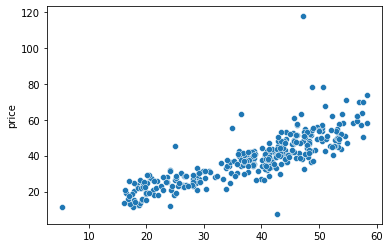

In [54]:
sns.scatterplot(y_hat_training, df_train[target])

In [64]:
# Run prediction!
y_hat_testing = lr.predict(Test_X_polied)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


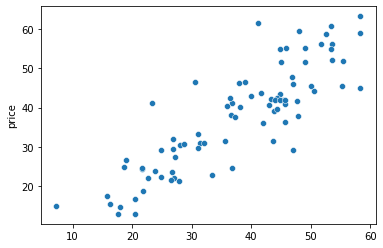

In [65]:
sns.scatterplot(y_hat_testing, df_test[target])

In [55]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

**Calculate MSE**

$(y - \hat{y})^2$

In [67]:
mean_squared_error(y_hat_training, df_train[target]), mean_squared_error(y_hat_testing, df_test[target])

(58.06285254938548, 44.785842212349365)

**Calculate MAE**

$|y - \hat{y}|$

In [66]:
# MAE is more meaningful than the MSE since not squared
mean_absolute_error(y_hat_training, df_train[target]), mean_absolute_error(y_hat_testing, df_test[target])

(4.973894564586458, 5.155182137454198)

In [58]:
df_train[target].mean()

38.08519637462236

In [59]:
# how closely did we fit
np.mean(abs(df_train[target] - y_hat_training / df_train[target] * 100))

66.58060418104692